## Introduction

Kaggle competition to build a model that predicts the total ride duration of taxi trips in New York City. The dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.



#### Prerequisites
This project is written in google colab, similar to jupyter-notebook and further instructions for work is written in this notebook

In [0]:
# import required libraries

# pandas for data loading and analysis
#numpy for mathematical operations
#for plotting matplolib and seaborn


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import MiniBatchKMeans
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"mraheel","key":"21b195bb21a44a801058141574cda75a"}'}

In [0]:
#ensure its there
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Jul 25 14:53 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#lets now download our dataset
!kaggle competitions download -c nyc-taxi-trip-duration

sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#unzip
!ls

'kaggle (1).json'   kaggle.json   sample_submission.zip   test.zip    train.zip
'kaggle (2).json'   sample_data   test.csv		  train.csv


In [0]:
!unzip train.zip
!unzip test.zip

Archive:  train.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
Archive:  test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


In [0]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [0]:
#saving id for test data prediction at the end
ID = df_test['id']

#### Data Dictionary

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to     the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and   forward trip
- trip_duration - duration of the trip in seconds

In [0]:
# head of data set
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [0]:
# description of data
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


The statistics description of data above of numeric values of features telling the count, mean, standard deviation, minimum and maximum number of frequency of a feature. It seems there is no missing value from their count value in above features.

But 'describe()' function also give insights for above data as the trip_duration has minimum value of '1 second' and maximum value of '3526282 seonds' meaning (approximately 980 hours) how can this be possible ? So there must be some outliers in the data that needs to be dealt with.

And below the data info tells us it has 11 number of columns with names

In [0]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134

(None, None)

In [0]:
def scatterplot(x, y, title):
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (9, 6))
    plt.ylim(40.6, 40.9)
    plt.xlim(-74.1,-73.7)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    ax.scatter(x, y, s=0.0002, alpha=1)
    plt.show()

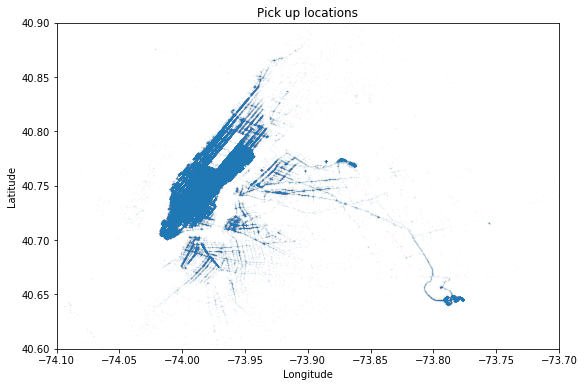

In [0]:
scatterplot(df_train['pickup_longitude'],df_train['pickup_latitude'], 'Pick up locations')

By plotting the pick up coordinates of our data, it seems like the map of city lets try to compare it with our test data to know if both are similar representatives of one another.
As expected both figures quite look alike.

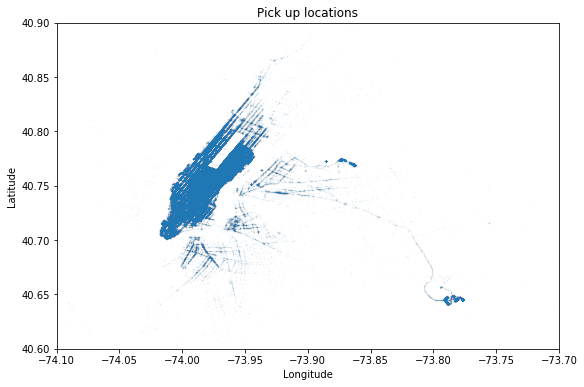

In [0]:
scatterplot(df_test['pickup_longitude'],df_test['pickup_latitude'], 'Pick up locations')

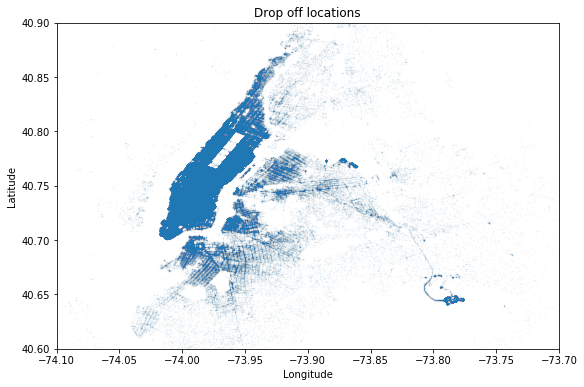

In [0]:
scatterplot(df_train['dropoff_longitude'], df_train['dropoff_latitude'], 'Drop off locations')

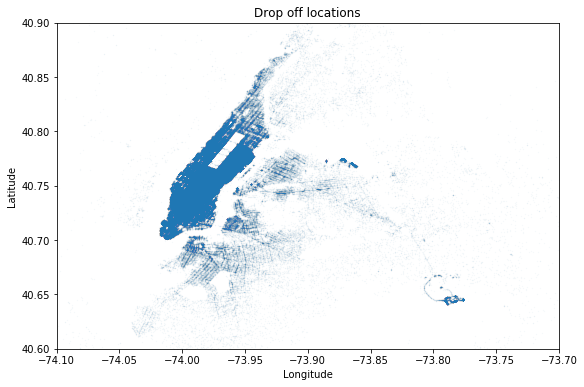

In [0]:
scatterplot(df_test['dropoff_longitude'], df_test['dropoff_latitude'], 'Drop off locations')

The graphs above enlightens that there is quite a trend in pickups and dropoffs so data is from
same distribution, let's find out more

lets handle the data to prepare it for further process, since data in raw form cannot be plotted and also cannot be used for model so it is to be dealt with.

Looking into it, the borders of NY City, in coordinates comes out to be:

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85) 

Comparing this to our `df_train.describe()` output we see that there are some coordinate points (pick ups/drop offs) that fall outside these borders. So let's limit our area of investigation to within the NY City borders.

In [0]:
df_train = df_train[df_train['pickup_longitude'] <= -73.75]
df_train = df_train[df_train['pickup_longitude'] >= -74.03]
df_train = df_train[df_train['pickup_latitude'] <= 40.85]
df_train = df_train[df_train['pickup_latitude'] >= 40.63]
df_train = df_train[df_train['dropoff_longitude'] <= -73.75]
df_train = df_train[df_train['dropoff_longitude'] >= -74.03]
df_train = df_train[df_train['dropoff_latitude'] <= 40.85]
df_train = df_train[df_train['dropoff_latitude'] >= 40.63]

In [0]:

# pickup datetime is very interesting it can be helpful for further demand for ride with respect to
# date, time, day of the week etc.
# we need to change the formatting of the date variables (`pickup_datetime` and `dropoff_datetime`).
#This will help a lot with data extraction in the coming section.

df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime) #Not in Test

let's find our more trends in our data, simply plot a timeseries line graph of both the test and training data to not only look into identifying possible trends/seasonality but to see if both data sets follow the same pattern shape. Reasonably we'd expect the two datasets to follow a very similar shape since the test data would be/is a randomly selected sample from the original dataset containing all data points. By picking the test points randomly, each data point has the same likelihood of being picked as a test point, thus ensuring uniformity in the test data sample.

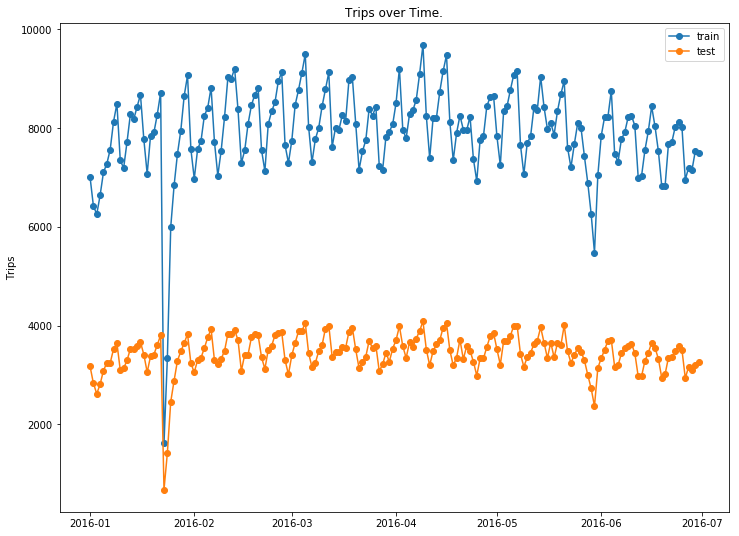

In [0]:

plt.figure(figsize = (12, 9))
plt.plot(df_train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(df_test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

Clearly the test and train datasets follow a very simila shape, as expected. A couple of points stand out at first glance. Around late-Jan/early-Feb there is a massive drop in the number of trips taken. A slightly less drastic drop is apparent about four months later. The first drop could be related to the season

In [0]:
df_train['Month'] = df_train['pickup_datetime'].dt.month
df_test['Month'] = df_test['pickup_datetime'].dt.month
df_train['DayofMonth'] = df_train['pickup_datetime'].dt.day
df_test['DayofMonth'] = df_test['pickup_datetime'].dt.day
df_train['Hour'] = df_train['pickup_datetime'].dt.hour
df_test['Hour'] = df_test['pickup_datetime'].dt.hour
df_train['DayofWeek'] = df_train['pickup_datetime'].dt.dayofweek
df_test['DayofWeek'] = df_test['pickup_datetime'].dt.dayofweek


df_train['dropoffMonth'] = df_train['pickup_datetime'].dt.month
df_train['dropoffDayofMonth'] = df_train['pickup_datetime'].dt.day
df_train['dropoffHour'] = df_train['pickup_datetime'].dt.hour
df_train['dropoffDayofWeek'] = df_train['pickup_datetime'].dt.dayofweek

In [0]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,Month,DayofMonth,Hour,DayofWeek
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,2016-06-30,6,30,23,3
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,2016-06-30,6,30,23,3
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,2016-06-30,6,30,23,3
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,2016-06-30,6,30,23,3
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,2016-06-30,6,30,23,3


In [0]:
df_train['store_and_fwd_flag'] = df_train['store_and_fwd_flag'].map({'Y': 0, 'N': 1})
df_test['store_and_fwd_flag'] = df_test['store_and_fwd_flag'].map({'Y': 0, 'N': 1})

In [0]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,Month,DayofMonth,Hour,DayofWeek,dropoffMonth,dropoffDayofMonth,dropoffHour,dropoffDayofWeek
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,1,455,2016-03-14,3,14,17,0,3,14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,1,663,2016-06-12,6,12,0,6,6,12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,1,2124,2016-01-19,1,19,11,1,1,19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,1,429,2016-04-06,4,6,19,2,4,6,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,1,435,2016-03-26,3,26,13,5,3,26,13,5


In [0]:
coordinates = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values))

In [0]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coordinates)

In [0]:
df_train.loc[:, 'pickup_cluster'] = kmeans.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test.loc[:, 'pickup_cluster'] = kmeans.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])

In [0]:
df_train['pickup_cluster'].shape

(1439183,)

<Figure size 864x648 with 0 Axes>

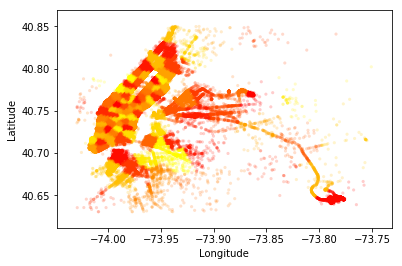

In [0]:
plt.figure(figsize = (12, 9))
fig, ax = plt.subplots(ncols = 1, nrows = 1)
ax.scatter(df_train.pickup_longitude.values[:500000], df_train.pickup_latitude.values[:500000], s = 10, lw = 0,
           c = df_train.pickup_cluster[:500000].values, cmap = 'autumn', alpha =0.2)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

A nice visual representation of the KMeans clustering algorithm at work (we used 100 clusters, but there is freedom to play around with this parameter to see how it changes the results). The clustering effectively created the different neighbourhoods in Manhattan as displayed by the borders between the different colors. This should be intuitive to some degree as a trip would differ from point A to point B, in various parts of New york. By nature, it's different.


As we now alreadyknow that we've outlier in our dataset, we have seen already in statistical summary of data in trip duration. Let's deal with that

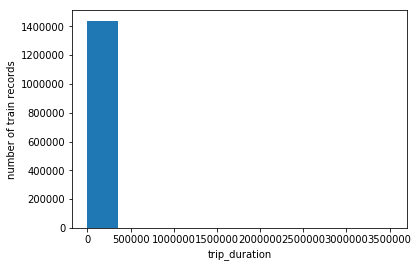

In [0]:
plt.hist(df_train['trip_duration'].values, bins=10)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

This is not making sense, what can we do with it, it is going to mess up with  our data so let's deal with it. We are having another opportunity to torture data again, now let's use log transformation and see what happens

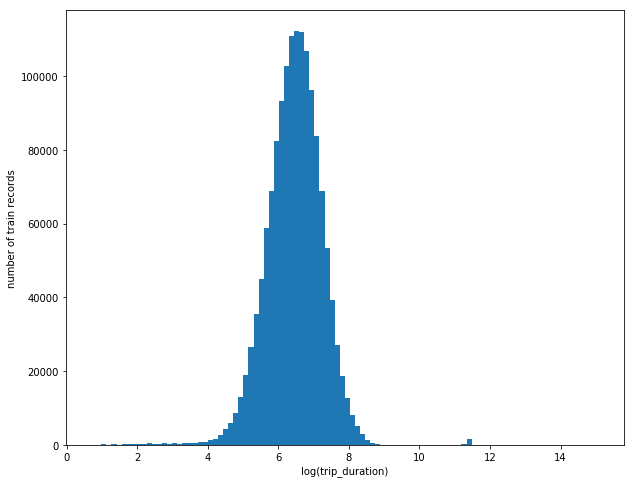

In [0]:
plt.figure(figsize = (10, 8))
df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values + 1)
plt.hist(df_train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [0]:
df_train.columns, df_test.columns

(Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
        'passenger_count', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
        'trip_duration', 'pickup_date', 'Month', 'DayofMonth', 'Hour',
        'DayofWeek', 'dropoffMonth', 'dropoffDayofMonth', 'dropoffHour',
        'dropoffDayofWeek', 'pickup_cluster', 'dropoff_cluster',
        'log_trip_duration'],
       dtype='object'),
 Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'Month',
        'DayofMonth', 'Hour', 'DayofWeek', 'pickup_cluster', 'dropoff_cluster'],
       dtype='object'))

The data we have also cyclical features, like hours of the day, day of the week and month of the year etc, also have to create dummy variables for some features, some features are going to be dropped

Now the magic happens. We map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sin and cos trigonometric functions.

If we plot to cyclical variable it will be as expected, this graph also illustrates the problem with presenting cyclical data to a machine learning algorithm: there are jump discontinuities in the graph at the end of each day.

In [0]:
def plot_cyclical(x):
  plt.figure(figsize = (8, 7))
  plt.plot(x)
  plt.show()

In [0]:
# sample for plotting
hour = df_train['Hour'][:30]
dayofmonth = df_train['DayofMonth'][:60]
dayofweek = df_train['DayofWeek'][:60]
month = df_train['Month'][:60]

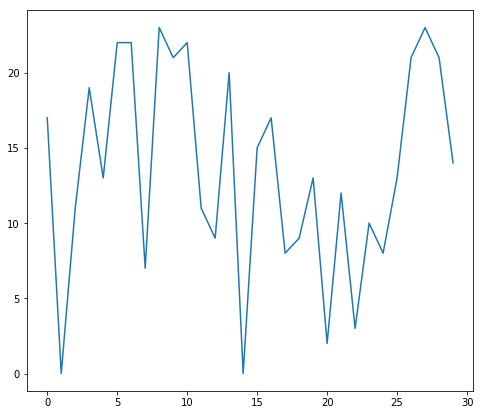

In [0]:
plot_cyclical(hour)

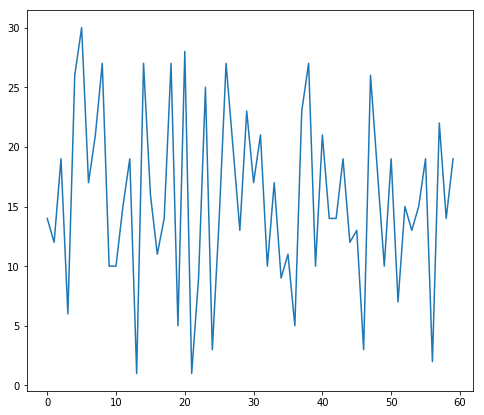

In [0]:
plot_cyclical(dayofmonth)

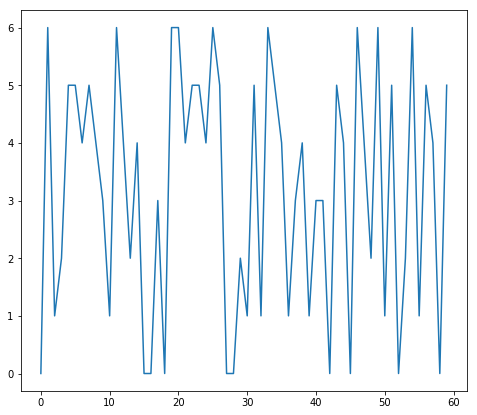

In [0]:
plot_cyclical(dayofweek)

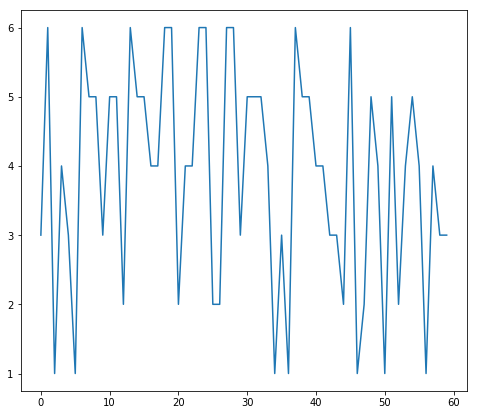

In [0]:
plot_cyclical(month)